# **Attention Based English-Wolayita Neural Machine Translation**

## Load important libraries

In [19]:
import re
import matplotlib.pyplot as plt
import time 
import numpy as np
import tensorflow as tf
from keras.layers import Embedding,LSTM,Dropout,Dense,Layer
from keras import Model,Input
from keras.utils import plot_model
from keras_preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.optimizers import Adam
import collections
import keras.backend as K

In [20]:
print(tf.__version__)

2.9.0


## **Preprocess dataset**







In [21]:
source = "English.txt"
target = "Wolayita.txt"

In [22]:
def preprocessing(source,target, max_num_input=26000):
    
    # open and read source and target datasets
    source_data = open(source,'r',encoding='utf8').readlines()
    target_data = open(target,'r',encoding='utf8').readlines()
    
    # check if source and target datasets are equal
    assert len(source_data) == len(target_data)
    
    print("Length of source Language :",len(source_data))
    print("Length of target Language :",len(target_data))
    
    # limit input data
    if max_num_input > 0:
        max_num_input = min(len(source_data), max_num_input)
        source_data = source_data[:max_num_input]
        target_data = target_data[:max_num_input]

    # changing to lowercase,remove punctuation, strip trailing/leading whitespaces and tokenize each sentence. 
    source_sen = [[re.sub('[\W]', '', str(token.lower() )) for token in sen.strip().split(' ')] for sen in source_data]
    
    # target
    target_sen = [[re.sub('[\W+0-6+8-9]', '', str(token.lower() )) for token in sen.strip().split(' ')] for sen in target_data]
    
    # # remove punctuation
    # target_sen = re.sub('[\W+0-6+8-9]', '', str(target_sen))
    
    # for the target sentences, add <sos> and <eos> tokens to each sentence 
    for sent in target_sen:
        sent.append('<end>')
        sent.insert(0,'<start>')

    # create the common_words objects for each file
    source_dict = common_words(source_sen)
    target_dict = common_words(target_sen)


    # For the source sentences. we'll use this to split into train/dev/test 
    split_size = len(source_sen)//10 
    
    # get the sents-as-ids for each sentence
    source_words = [[source_dict.word2ids.get(token,source_dict.UNK) for token in sen] for sen in source_sen]
    
    
    # Use 8 parts (80%) of the sentences for training and  pad upto maximum sentence length
    source_train = pad_sequences(source_words[:8*split_size],padding='post')
    
    # Use 1 parts (10%) of the sentences for evaluation and pad upto maximum sentence length
    source_eva = pad_sequences(source_words[8*split_size:9*split_size],padding='post')
    
    # Use 1 parts (10%) of the sentences for test and pad upto maximum sentence length
    source_test = pad_sequences(source_words[9*split_size:],padding='post')


    eos = target_dict.word2ids['<end>'] 
    
    # for each sentence, get the word index for the tokens from <start> to up to but not including <end>,
    target_words = [[target_dict.word2ids.get(tok,target_dict.UNK) for tok in sent[:-1]] for sent in target_sen]
    
    # select the training set and pad the sentences
    target_train = pad_sequences(target_words[:8*split_size],padding='post')
    
    # the label for each target word is the next word after it
    target_train_labels = [sent[1:]+[eos] for sent in target_words[:8*split_size]]
    
    # pad the labels. Dim = [num_sents, max_sent_lenght]
    target_train_labels = pad_sequences(target_train_labels,padding='post')
    
    # expand dimensions Dim = [num_sents, max_sent_lenght, 1]. 
    target_train_labels = np.expand_dims(target_train_labels,axis=2)

    # get the labels for the dev and test data. No need for inputs here. no need to expand dimensions
    target_eva_labels = pad_sequences([sent[1:] + [eos] for sent in target_words[8 * split_size:9 * split_size]], padding='post')
    target_test_labels = pad_sequences([sent[1:] + [eos] for sent in target_words[9 * split_size:]], padding='post')
      
    # we have our data.
    train_data = [source_train,target_train,target_train_labels]
    eva_data = [source_eva,target_eva_labels]
    test_data = [source_test,target_test_labels]

    return train_data,eva_data,test_data,source_dict,target_dict


## **common_words**


In [23]:
# Extract common words from dataset
class common_words():
    def __init__(self, sents):
        word_counter = collections.Counter(tok.lower() for sent in sents for tok in sent)

        self.vocab = []
        self.vocab.append('<pad>') #zero paddings
        self.vocab.append('<unk>')
        # add only words that appear at least 4 times in the corpus
        self.vocab.extend([t for t,c in word_counter.items() if c > 10])

        self.word2ids = {w:id for id, w in enumerate(self.vocab)}
        self.ids2word = dict([(value, key) for (key, value) in self.word2ids.items()])
        self.UNK = self.word2ids['<unk>']
        self.PAD = self.word2ids['<pad>']

## Load the datasets

Let's load the datasets using the load function defined earlier.

In [24]:
train_data,eva_data,test_data,source_dict,target_dict = preprocessing(source,target, max_num_input=26000)

Length of source Language : 26943
Length of target Language : 26943


let's now quickly check the data structure.

In [25]:
eva_data[0]

array([[1534,  154, 2001, ...,    0,    0,    0],
       [ 417,  254,  149, ...,    0,    0,    0],
       [ 787,  117,  154, ...,    0,    0,    0],
       ...,
       [   2, 2791,   33, ...,    0,    0,    0],
       [   6,   18,  415, ...,    0,    0,    0],
       [   6,  135,  150, ...,    0,    0,    0]], dtype=int32)

In [26]:
test_data

[array([[555, 163,  61, ...,   0,   0,   0],
        [163, 734,  38, ...,   0,   0,   0],
        [ 18, 773,  38, ...,   0,   0,   0],
        ...,
        [ 66, 417,   1, ...,   0,   0,   0],
        [150, 207,  46, ...,   0,   0,   0],
        [149,  45, 303, ...,   0,   0,   0]], dtype=int32),
 array([[ 215,   31,  171, ...,    0,    0,    0],
        [4345, 1853, 4140, ...,    0,    0,    0],
        [2008,  598,  461, ...,    0,    0,    0],
        ...,
        [   1,  524, 1879, ...,    0,    0,    0],
        [ 341,  342,  129, ...,    0,    0,    0],
        [ 340, 1867,  126, ...,    0,    0,    0]], dtype=int32)]

## **The Neural Translation Model (NMT)**

For the NMT the network (a system of connected layers/models) used for training differs slightly from the network used for inference. Both use the the seq-to-seq encoder-decoder architecture. 




In [27]:
class AttentionLayer(Layer):
    
    
    def compute_mask(self, inputs, mask=None):
        if mask == None:
            return None
        return mask[1]

    def compute_output_shape(self, input_shape):
        return (input_shape[1][0],input_shape[1][1],input_shape[1][2]*2)


    def call(self, inputs, mask=None):
        encoder_outputs, decoder_outputs = inputs

        decoder_outputs_transpose = K.permute_dimensions(decoder_outputs,pattern = (0,2,1))
        luong_score = K.batch_dot(encoder_outputs,decoder_outputs_transpose)
        luong_score = tf.nn.softmax(luong_score,axis = 1)
        encoder_vector = tf.math.multiply(tf.expand_dims(encoder_outputs,axis = -2) , tf.expand_dims(luong_score,axis = -1) )
        encoder_vector = tf.reduce_sum(encoder_vector,axis=1)

        # [batch,max_dec,2*emb]
        new_decoder_outputs = K.concatenate([decoder_outputs, encoder_vector])

        return new_decoder_outputs

In [38]:
class seq2seqModel(object):
    def __init__(self,source_dict,target_dict,use_attention):
        
        # the number of hidden units used by the LSTM
        self.hidden_size = 200
        
        # the size of the word embeddings being used
        self.embedding_size = 100
        
        # the dropout rate for the hidden layers
        self.hidden_dropout_rate=0.2
        
        # the dropout rate for the word embeddings
        self.embedding_dropout_rate = 0.2
        # batch size
        self.batch_size = 100

        # the maximum length of the target sentences
        self.max_target_step = 100

        # vocab size for source and target; we'll use everything we receive
        self.vocab_target_size = len(target_dict.vocab)
        self.vocab_source_size = len(source_dict.vocab)

        # intances of the dictionaries
        self.target_dict = target_dict
        self.source_dict = source_dict

        # special tokens to indicate sentence starts and ends.
        self.SOS = target_dict.word2ids['<start>']
        self.EOS = target_dict.word2ids['<end>']

        # use attention or no
        self.use_attention = use_attention

        print("number of tokens in source: %d, number of tokens in target:%d" % (self.vocab_source_size,self.vocab_target_size))



    def build(self):
        
        #-------------------------Train Models------------------------------
        source_words = Input(shape=(None,),dtype='int32')
        target_words = Input(shape=(None,), dtype='int32')

        # The train encoder
        #  Create two randomly initialized embedding lookups, one for the source, another for the target. 
        # Creating the embedding lookups...
        embeddings_source = Embedding(self.vocab_source_size,self.embedding_size)
        embeddings_target = Embedding(self.vocab_target_size,self.embedding_size)

        # Look up the embeddings for source words and for target words. Apply dropout to each encoded input
        # Looking up source and target words...'
        source_word_embeddings = Dropout(0.3)(embeddings_source(source_words))

        target_words_embeddings = Dropout(0.3)(embeddings_target(target_words))

        #  An encoder LSTM() with return sequences set to True
        #  Creating an encoder'
        encoder_outputs, encoder_state_h, encoder_state_c = LSTM(self.hidden_size,recurrent_dropout=self.hidden_dropout_rate,return_sequences=True,return_state=True)(source_word_embeddings)
        
        encoder_states = [encoder_state_h,encoder_state_c]

        # The train decoder
        decoder_lstm = LSTM(self.hidden_size,recurrent_dropout=self.hidden_dropout_rate,return_sequences=True,return_state=True)
        decoder_outputs_train,_,_ = decoder_lstm(target_words_embeddings,initial_state=encoder_states)

        if self.use_attention:
            decoder_attention = AttentionLayer()
            decoder_outputs_train = decoder_attention([encoder_outputs,decoder_outputs_train])


        decoder_dense = Dense(self.vocab_target_size,activation='softmax')
        decoder_outputs_train = decoder_dense(decoder_outputs_train)

        # compiling the train model.
        adam = Adam(learning_rate=0.01,clipnorm=5.0)
        self.train_model = Model([source_words,target_words], decoder_outputs_train)
        self.train_model.compile(optimizer=adam,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # at this point you can print model summary for the train model
        print('\t\t\t\t\t\t Train Model Summary.')
        self.train_model.summary()
        print(plot_model(self.train_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True))

        #-------------------------Inference Models------------------------------
        # The inference encoder 
        self.encoder_model = Model(source_words,[encoder_outputs,encoder_state_h,encoder_state_c])
        # at this point you can print the summary for the encoder model.
        print('\t\t\t\t\t\t Inference Time Encoder Model Summary.')
        self.encoder_model.summary()

        # The decoder model
        # specifying the inputs to the decoder
        decoder_state_input_h = Input(shape=(self.hidden_size,))
        decoder_state_input_c = Input(shape=(self.hidden_size,))
        encoder_outputs_input = Input(shape=(None,self.hidden_size,))

   
        # create decoder for inference
        
        #  Get the decoded outputs
        # print('\n Putting together the decoder states')
        # get the inititial states for the decoder, decoder_states
        # decoder states are the hidden and cell states from the training stage
        decoder_states = [decoder_state_input_h,decoder_state_input_c]
        # use decoder states as input to the decoder lstm to get the decoder outputs, h, and c for test time inference
        decoder_outputs_test,decoder_state_output_h, decoder_state_output_c = decoder_lstm(target_words_embeddings, initial_state=decoder_states)

        # Task 1 (b.) Add attention if attention

        if self.use_attention:
            decoder_outputs_test = decoder_attention([encoder_outputs_input,decoder_outputs_test])

        # Task 1 (c.) pass the decoder_outputs_test (with or without attention) to the decoder dense layer
        decoder_outputs_test = decoder_dense(decoder_outputs_test)
        
        # put the model together
        self.decoder_model = Model([target_words,decoder_state_input_h,decoder_state_input_c,encoder_outputs_input],
                                   [decoder_outputs_test,decoder_state_output_h,decoder_state_output_c])
        # you can now view the model summary
        print('\t\t\t\t\t\t Decoder Inference Model summary')
        print(self.decoder_model.summary())
        



    def time_used(self, start_time):
        curr_time = time.time()
        used_time = curr_time-start_time
        m = used_time // 60
        s = used_time - 60 * m
        return "%d m %d s" % (m, s)



    def train(self,train_data,dev_data,test_data, epochs):
        start_time = time.time()
        # for epoch in range(epochs):
        # print("Starting training epoch {}/{}".format(epoch + 1, epochs))
        epoch_time = time.time()
        source_words_train, target_words_train, target_words_train_labels = train_data

        self.history=self.train_model.fit([source_words_train,target_words_train],target_words_train_labels,batch_size=self.batch_size,epochs=epochs)

        # print("Time used for epoch {}: {}".format(epoch + 1, self.time_used(epoch_time)))
        dev_time = time.time()
        # print("Evaluating on dev set after epoch {}/{}:".format(epoch + 1, epochs))
        # self.eval(dev_data)
        # print("Time used for evaluate on dev set: {}".format(self.time_used(dev_time)))
        
        self.train_model.save('aeng_wol_model.h5') 
        
        self.encoder_model.save('aeng_wol_modele.h5')
        self.decoder_model.save('aeng_wol_modeld.h5')
        print("Training finished!")
        print("Time used for training: {}".format(self.time_used(start_time)))

        print("Evaluating on test set:")
        test_time = time.time()
        self.eval(test_data)
        print("Time used for evaluate on test set: {}".format(self.time_used(test_time)))
        
        


    def get_target_sentences(self, sents,vocab,reference=False):
        str_sents = []
        num_sent, max_len = sents.shape
        for i in range(num_sent):
            str_sent = []
            for j in range(max_len):
                t = sents[i,j].item()
                if t == self.SOS:
                    continue
                if t == self.EOS:
                    break

                str_sent.append(vocab[t])
            if reference:
                str_sents.append([str_sent])
            else:
                str_sents.append(str_sent)
        return str_sents



    def eval(self, dataset,print_outputs = False):
        
        # get the source words and target_word_labels for the eval dataset
        source_words, target_words = dataset
        vocab = self.target_dict.vocab

        # using the same encoding network used during training time, encode the training
        encoder_outputs, state_h,state_c = self.encoder_model.predict(source_words,batch_size=self.batch_size)
        
        # for max_target_step steps, feed the step target words into the decoder.
        predictions = []
        step_target_words = np.ones([source_words.shape[0],1]) * self.SOS
        
        for _ in range(self.max_target_step):
            step_decoder_outputs, state_h,state_c = self.decoder_model.predict([step_target_words,state_h,state_c,encoder_outputs],batch_size=self.batch_size)
            step_target_words = np.argmax(step_decoder_outputs,axis=2)
            predictions.append(step_target_words)

        # predictions is a [time_step x batch_size x 1] array. We use get_target_sentence() to recover the batch_size sentences
        predicted = self.get_target_sentences(np.concatenate(predictions,axis=1),vocab)
        Actual = self.get_target_sentences(target_words,vocab,reference=True)

        # score using nltk bleu scorer
        score = corpus_bleu(Actual,predicted)
        print("Model BLEU score: %.2f" % (score*100.0))
    

        #Modification
        if print_outputs:
            sources = self.get_target_sentences(np.array(source_words[0:len(source_words)]),self.source_dict.vocab)
            return sources,  predicted, Actual



## **Training Without Attention**


### Architecture

In [29]:
#Clear session prior to creating the architecture
tf.keras.backend.clear_session()
model = seq2seqModel(source_dict, target_dict,False)
model.build()

number of tokens in source: 3078, number of tokens in target:4742
						 Train Model Summary.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    307800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    474200      ['input_2[0][0]']                


### Training and test evaluation 

In [31]:
model.train(train_data,eva_data,test_data,50) 

Epoch 1/50
208/208 [==============================] - 67s 322ms/step - loss: 1.1861 - accuracy: 0.8425
Epoch 2/50
208/208 [==============================] - 67s 322ms/step - loss: 1.0206 - accuracy: 0.8518
Epoch 3/50
208/208 [==============================] - 67s 322ms/step - loss: 0.9505 - accuracy: 0.8542
Epoch 4/50
208/208 [==============================] - 67s 322ms/step - loss: 0.9084 - accuracy: 0.8557
Epoch 5/50
208/208 [==============================] - 67s 323ms/step - loss: 0.8781 - accuracy: 0.8568
Epoch 6/50
208/208 [==============================] - 67s 322ms/step - loss: 0.8544 - accuracy: 0.8576
Epoch 7/50
208/208 [==============================] - 67s 322ms/step - loss: 0.8375 - accuracy: 0.8580
Epoch 8/50
208/208 [==============================] - 67s 321ms/step - loss: 0.8192 - accuracy: 0.8588
Epoch 9/50
208/208 [==============================] - 67s 321ms/step - loss: 0.8050 - accuracy: 0.8594
Epoch 10/50
208/208 [==============================] - 67s 321ms/step - l

### plo model history

In [32]:
model.history.history['loss']

[1.1861499547958374,
 1.0205885171890259,
 0.9505376815795898,
 0.9083749651908875,
 0.8781290650367737,
 0.8543962240219116,
 0.8375205397605896,
 0.8191867470741272,
 0.8050171136856079,
 0.7925382852554321,
 0.7787625789642334,
 0.7666164040565491,
 0.7575007081031799,
 0.7495518922805786,
 0.7423750162124634,
 0.736233115196228,
 0.730194628238678,
 0.725242018699646,
 0.7203042507171631,
 0.7155888676643372,
 0.7115890979766846,
 0.707652747631073,
 0.7046445608139038,
 0.7008569240570068,
 0.6979492902755737,
 0.6947996020317078,
 0.691929042339325,
 0.6889551281929016,
 0.6858614087104797,
 0.6843018531799316,
 0.6814482808113098,
 0.6793508529663086,
 0.6774718761444092,
 0.6754162311553955,
 0.6732808947563171,
 0.671392023563385,
 0.6690316200256348,
 0.6669567227363586,
 0.6655371189117432,
 0.6642995476722717,
 0.6622121930122375,
 0.6596799492835999,
 0.6580064296722412,
 0.6558746695518494,
 0.6535468697547913,
 0.6514220237731934,
 0.6507473587989807,
 0.6496177911758423

In [33]:
model.history.history['accuracy']

[0.8425235748291016,
 0.8517621755599976,
 0.8542322516441345,
 0.8557025194168091,
 0.8567930459976196,
 0.8575515151023865,
 0.8580357432365417,
 0.8588014841079712,
 0.8594039678573608,
 0.8598896265029907,
 0.8607780337333679,
 0.8613775372505188,
 0.861728310585022,
 0.8619623184204102,
 0.8624013662338257,
 0.8627756834030151,
 0.8630185723304749,
 0.863216757774353,
 0.863491952419281,
 0.8639246225357056,
 0.8640973567962646,
 0.8642876744270325,
 0.864425539970398,
 0.864619791507721,
 0.864986777305603,
 0.8651285171508789,
 0.8652144074440002,
 0.865420937538147,
 0.8657427430152893,
 0.8656426668167114,
 0.866030216217041,
 0.8661131262779236,
 0.8662450909614563,
 0.8663456439971924,
 0.8665551543235779,
 0.8667121529579163,
 0.8667553067207336,
 0.8670511245727539,
 0.866885781288147,
 0.8672772645950317,
 0.8674656748771667,
 0.8678758144378662,
 0.8681490421295166,
 0.8685071468353271,
 0.8686474561691284,
 0.8689864873886108,
 0.868912398815155,
 0.8690968155860901,
 0

In [ ]:
model.history.history.keys()

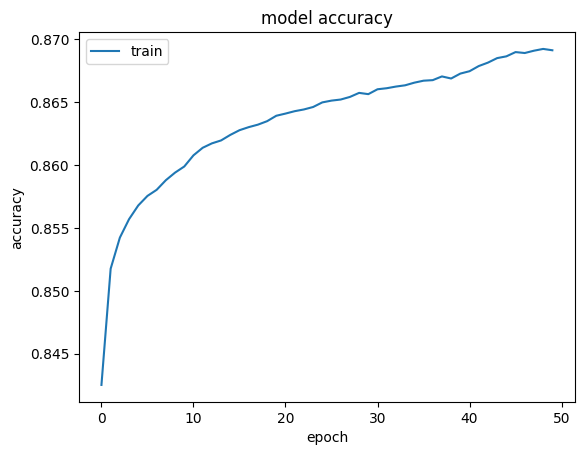

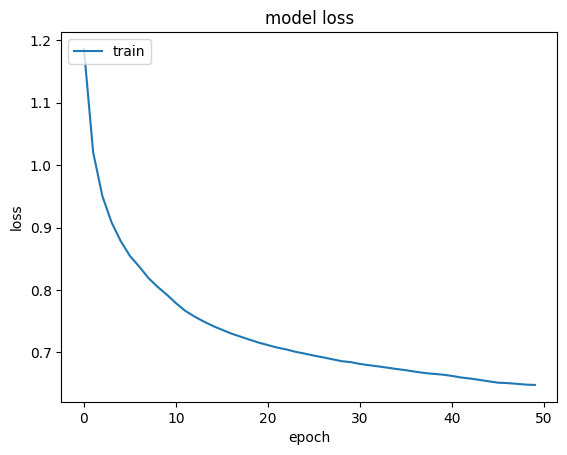

In [34]:
model.history.history.keys()
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
# plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(model.history.history['loss'])
# plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [35]:
def eval1( dataset,print_outputs = False):
        
        # get the source words and target_word_labels for the eval dataset
        source_words = dataset
        vocab = model.target_dict.vocab
        loaded_modele = tf.keras.models.load_model('eng_wol_modele.h5', compile=False)
    
        # using the same encoding network used during training time, encode the training
        encoder_outputs, state_h,state_c = loaded_modele.predict(source_words,batch_size=model.batch_size)
        
        # for max_target_step steps, feed the step target words into the decoder.
        predictions = []
        step_target_words = np.ones([source_words.shape[0],1]) * model.SOS
        
        loaded_modeld = tf.keras.models.load_model('eng_wol_modeld.h5', compile=False)
        for _ in range(model.max_target_step):
            step_decoder_outputs, state_h,state_c = loaded_modeld.predict([step_target_words,state_h,state_c,encoder_outputs],batch_size=model.batch_size)
            step_target_words = np.argmax(step_decoder_outputs,axis=2)
            predictions.append(step_target_words)

        # predictions is a [time_step x batch_size x 1] array. We use get_target_sentence() to recover the batch_size sentences
        predicted = model.get_target_sentences(np.concatenate(predictions,axis=1),vocab)
        
        #Modification
        if print_outputs:
            sources = model.get_target_sentences(np.array(source_words[0:len(source_words)]),model.source_dict.vocab)
            return sources,  predicted

def proprocessing(source):

    # changing to lowercase,remove punctuation, strip trailing/leading whitespaces and tokenize each sentence.
    a=[]
    source_sen = [re.sub('[\W]', '', str(token.lower() )) for token in source.split(' ')] 
    a.append(source_sen)
   
    # get the sents-as-ids for each sentence
    source_words = [[source_dict.word2ids.get(token,source_dict.UNK) for token in sen] for sen in a]
    print('source_words',source_words)

    source_test = pad_sequences(source_words,padding='post')
    


    return source_test

def translate2( ):
    # Prints out a set number of translations from the test set
    data=input('Please enter the text input: ')

    data=proprocessing(data)
    
    sources,  candidates = eval1(data,print_outputs=True)
    
    example_no = 2
    for i in range(example_no-1):
        print(f"Output:{i+1}")
        print(f"Source sentence: {' '.join(sources[i]).replace('<pad>', '').replace('<unk>', '')}")
        print(f"Predicted translation: {' '.join(candidates[i]).replace('<pad>', '').replace('<unk>', '')}")
        


        

In [37]:
translate2()

Please enter the text input:  I'm a little bit tired


source_words [[1, 154, 1686, 1, 1]]
1/1 [==============================] - 0s 20ms/step
Output:1
Source sentence:  a little  
Predicted translation: ceega gidiiddi gibxxetu  


In [ ]:
# load HDF5 format
#loaded_model = tf.keras.models.load_model('eng_wol_model.h5')


In [39]:
def translate(model, sentence = 15):
    # data=input()
    sources,  Predicted, Actual = model.eval(test_data,print_outputs=True)
    for i in range(sentence-1):
        print(f"example:{i+1}")
        print(f"Source sentence: {' '.join(sources[i]).replace('<pad>', '').replace('<unk>', '')}")
        print(f"Predicted translation: {' '.join(Predicted[i]).replace('<pad>', '').replace('<unk>', '')}")
        print(f"Actual translation: {' '.join([l[0] for l in Actual][i]).replace('<pad>', '').replace('<unk>', '')}")

In [40]:
# load HDF5 format
# loaded_model = tf.keras.models.load_model('eng_wol_model.h5')
translate(model)

26/26 [==============================] - 0s 2ms/step
Model BLEU score: 2.35
example:1
Source sentence: wherefore they are no more twain but one flesh what therefore god hath joined together let not man put asunder                                              
Predicted translation: hegaa gishshau            
Actual translation: hegaa gishshau eti issi asa gidiyoogaappe attin naa77u asa gidokkona hegaa gishshau xoossai issippe  asi  yaagiis
example:2
Source sentence: they say unto him why did moses then command to give a writing of  and to put her away                                              
Predicted translation: hegaappe guyyiyan kawoi                                                
Actual translation: parisaaweti yesuusa âœyaatin muusee aissi issi urai ba  paramaa immidi yeddana mala  yaagidosona
example:3
Source sentence: he saith unto them moses because of  of your hearts suffered you to put away your wives but from beginning it was not so                                     

## **Training with Attention**

The inputs to the attention layer are encoder and decoder outputs. The attention mechanism:
1. Computes a score (a luong score) for each source word
2. Weights the words by their luong scores.
3. Concatenates the wieghted encoder representation with the decoder_ouput.
This new decoder output will now be the input to the decoder_dense layer. 



### Architecture

In [41]:
#Clear session prior to creating the architecture
tf.keras.backend.clear_session()
model_attention = seq2seqModel(source_dict, target_dict,True)
model_attention.build()

number of tokens in source: 3078, number of tokens in target:4742
						 Train Model Summary.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    307800      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, None, 100)    0           ['embedding[0][0]']              


### Training and test evaluation 

In [ ]:
model_attention.train(train_data,eva_data,test_data,50)

Epoch 1/50
208/208 [==============================] - 77s 369ms/step - loss: 0.7974 - accuracy: 0.8634
Epoch 2/50
208/208 [==============================] - 77s 370ms/step - loss: 0.7323 - accuracy: 0.8670
Epoch 3/50
208/208 [==============================] - 77s 371ms/step - loss: 0.6863 - accuracy: 0.8702
Epoch 4/50
208/208 [==============================] - 77s 371ms/step - loss: 0.6506 - accuracy: 0.8725
Epoch 5/50
208/208 [==============================] - 77s 370ms/step - loss: 0.6225 - accuracy: 0.8749
Epoch 6/50
208/208 [==============================] - 77s 370ms/step - loss: 0.5989 - accuracy: 0.8768
Epoch 7/50
208/208 [==============================] - 77s 370ms/step - loss: 0.5803 - accuracy: 0.8785
Epoch 8/50
208/208 [==============================] - 77s 372ms/step - loss: 0.5636 - accuracy: 0.8802
Epoch 9/50
208/208 [==============================] - 77s 372ms/step - loss: 0.5496 - accuracy: 0.8814
Epoch 10/50
208/208 [==============================] - 77s 370ms/step - l

In [55]:
model_attention.history.history['loss']

[0.7974122166633606,
 0.7323060631752014,
 0.6863067150115967,
 0.6506105661392212,
 0.6224511861801147,
 0.5988711714744568,
 0.5802743434906006,
 0.5636193156242371,
 0.5496373176574707,
 0.5377209186553955,
 0.5269734263420105,
 0.5172516107559204,
 0.5092537999153137,
 0.5017974972724915,
 0.4948137104511261,
 0.48817139863967896,
 0.4826236069202423,
 0.47756022214889526,
 0.4733218252658844,
 0.46886569261550903,
 0.4651045501232147,
 0.4607211649417877,
 0.45780542492866516,
 0.4537016749382019,
 0.45127591490745544,
 0.44807612895965576,
 0.4459756314754486,
 0.4429103434085846,
 0.44022682309150696,
 0.43845459818840027,
 0.4364568293094635,
 0.433860719203949,
 0.43199893832206726,
 0.430285781621933,
 0.42852097749710083,
 0.42573872208595276,
 0.4250275492668152,
 0.42293739318847656,
 0.421938955783844,
 0.42059609293937683,
 0.41918763518333435,
 0.4181117117404938,
 0.4170166552066803,
 0.41553306579589844,
 0.4137488305568695,
 0.41302400827407837,
 0.4124312102794647,


In [56]:
model_attention.history.history['accuracy']

[0.8634095191955566,
 0.8670138120651245,
 0.870162844657898,
 0.872532844543457,
 0.8749401569366455,
 0.8767567873001099,
 0.8784841299057007,
 0.8801864385604858,
 0.8813849091529846,
 0.8826138377189636,
 0.8840163946151733,
 0.8850593566894531,
 0.8857770562171936,
 0.8867204785346985,
 0.8877825736999512,
 0.8885704278945923,
 0.8890291452407837,
 0.8898798227310181,
 0.8904204368591309,
 0.8908501863479614,
 0.8915414214134216,
 0.8919554352760315,
 0.8924053311347961,
 0.8932510614395142,
 0.8934364914894104,
 0.8937828540802002,
 0.8941277265548706,
 0.8945329785346985,
 0.8949244618415833,
 0.8951103687286377,
 0.8955092430114746,
 0.8958923816680908,
 0.8962779641151428,
 0.8964104056358337,
 0.8967915773391724,
 0.8970510959625244,
 0.8973587155342102,
 0.8976962566375732,
 0.8975549340248108,
 0.8979302644729614,
 0.8981887698173523,
 0.8983099460601807,
 0.8984600901603699,
 0.8986528515815735,
 0.899024248123169,
 0.8990737795829773,
 0.8991522789001465,
 0.8991400003433

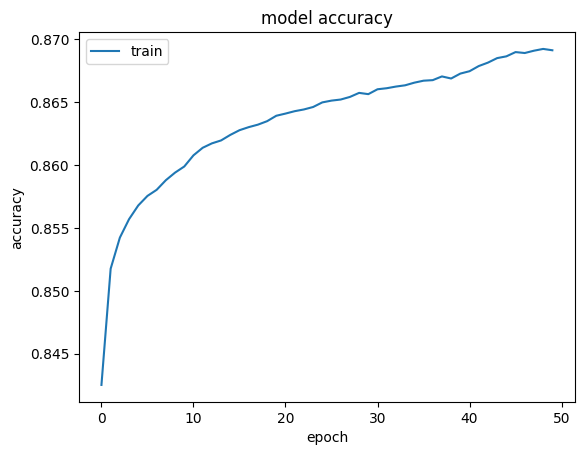

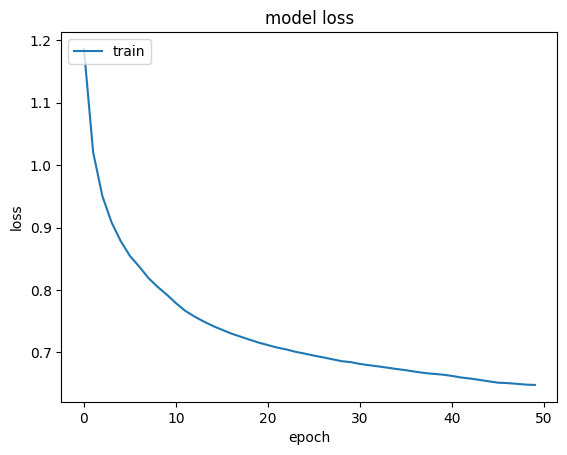

In [57]:
model.history.history.keys()
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
# plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(model.history.history['loss'])
# plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# plot_model(model_attention, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [58]:
translate(model_attention)

26/26 [==============================] - 0s 4ms/step
Model BLEU score: 4.59
example:1
Source sentence: wherefore they are no more twain but one flesh what therefore god hath joined together let not man put asunder                                              
Predicted translation: hegaa gishshau eti naa77u qofan issuwaa issuwaa gidiyo gishshau attumaasa xayidi  ainne 
Actual translation: hegaa gishshau eti issi asa gidiyoogaappe attin naa77u asa gidokkona hegaa gishshau xoossai issippe  asi  yaagiis
example:2
Source sentence: they say unto him why did moses then command to give a writing of  and to put her away                                              
Predicted translation: âœasai   aissi giikko a      
Actual translation: parisaaweti yesuusa âœyaatin muusee aissi issi urai ba  paramaa immidi yeddana mala  yaagidosona
example:3
Source sentence: he saith unto them moses because of  of your hearts suffered you to put away your wives but from beginning it was not so                 

### Translate from user input

In [59]:
def eval1( dataset,print_outputs = False):
        
        # get the source words and target_word_labels for the eval dataset
        source_words = dataset
        vocab = model.target_dict.vocab
        loaded_modele = tf.keras.models.load_model('aeng_wol_modele.h5', compile=False)
    
        # using the same encoding network used during training time, encode the training
        encoder_outputs, state_h,state_c = loaded_modele.predict(source_words,batch_size=model.batch_size)
        
        # for max_target_step steps, feed the step target words into the decoder.
        predictions = []
        step_target_words = np.ones([source_words.shape[0],1]) * model.SOS
        
        loaded_modeld = tf.keras.models.load_model('aeng_wol_modeld.h5', compile=False, custom_objects={"AttentionLayer": AttentionLayer })
        for _ in range(model.max_target_step):
            step_decoder_outputs, state_h,state_c = loaded_modeld.predict([step_target_words,state_h,state_c,encoder_outputs],batch_size=model.batch_size)
            step_target_words = np.argmax(step_decoder_outputs,axis=2)
            predictions.append(step_target_words)

        # predictions is a [time_step x batch_size x 1] array. We use get_target_sentence() to recover the batch_size sentences
        predicted = model.get_target_sentences(np.concatenate(predictions,axis=1),vocab)
        
        #Modification
        if print_outputs:
            sources = model.get_target_sentences(np.array(source_words[0:len(source_words)]),model.source_dict.vocab)
            return sources,  predicted

def proprocessing(source):

    # changing to lowercase,remove punctuation, strip trailing/leading whitespaces and tokenize each sentence.
    a=[]
    source_sen = [re.sub('[\W]', '', str(token.lower() )) for token in source.split(' ')] 
    a.append(source_sen)
   
    # get the sents-as-ids for each sentence
    source_words = [[source_dict.word2ids.get(token,source_dict.UNK) for token in sen] for sen in a]
    print('source_words',source_words)

    source_test = pad_sequences(source_words,padding='post')
    


    return source_test

def translate2( ):
    # Prints out a set number of translations from the test set
    data=input('Please enter the text input: ')

    data=proprocessing(data)
    
    sources,  candidates = eval1(data,print_outputs=True)
    
    example_no = 2
    for i in range(example_no-1):
        print(f"Output:{i+1}")
        print(f"Source sentence: {' '.join(sources[i]).replace('<pad>', '').replace('<unk>', '')}")
        print(f"Predicted translation: {' '.join(candidates[i]).replace('<pad>', '').replace('<unk>', '')}")
        


        

In [60]:
translate2()

Please enter the text input:  jesus christ


source_words [[1354, 1355]]
1/1 [==============================] - 0s 21ms/step
Output:1
Source sentence: jesus christ
Predicted translation: yesuus kiristtoosi yesuus kiristtoosa wonggeliyaa wode yesuus kiristtoosa wonggeliyaa wode yesuus kiristtoosa qoppa
